# Topic Modeling

## Import

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.dates

import seaborn as sns

from src.progress_bar import printProgressBar

from ast import literal_eval

import gensim
import gensim.corpora as corpora
from gensim.models import TfidfModel

import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models.callbacks import Metric

class ProgressBar(Metric):
    """Metric class for perplexity evaluation."""
    def __init__(self, corpus=None, logger=None, viz_env=None, title=None, passes=None):
        self.corpus = corpus
        self.logger = logger
        self.viz_env = viz_env
        self.title = title
        self.i = 0
        self.passes = passes

    def get_value(self, **kwargs):
        self.i+=1
        printProgressBar(self.i, self.passes, prefix='Progress:', suffix='Complete', length=50)

import spacy

import json

import os
for dirname, _, filenames in os.walk('../../data/lyrics'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\", "/"))

print(50 * '-')

for dirname, _, filenames in os.walk('../../data/billboard'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\", "/"))

../../data/lyrics/artist_song_lyrics.csv
../../data/lyrics/artist_song_lyrics_new.csv
../../data/lyrics/bb-t100-lyrics.csv
../../data/lyrics/bb-t100-lyrics_new.csv
../../data/lyrics/bb_t100_lyrics_en.csv
../../data/lyrics/bb_t100_lyrics_en_new.csv
../../data/lyrics/covid_lyrics_bb.csv
../../data/lyrics/lyrics_invalid.json
../../data/lyrics/lyrics_invalid_new.json
../../data/lyrics/lyrics_invalid_updated.csv
../../data/lyrics/lyrics_invalid_updated_new.csv
../../data/lyrics/backups/artist_song_lyrics_bak.csv
../../data/lyrics/backups/bb-t100-lyrics.csv
../../data/lyrics/backups/bb-t100-lyrics_new.csv
../../data/lyrics/backups/bb-t100-lyrics_old.csv
../../data/lyrics/backups/bb_t100_lyrics_en.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v1.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v2.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v3.csv
../../data/lyrics/backups/corona-lyrics.csv
../../data/lyrics/backups/lyrics_invalid_updated.csv
----------------------------------------------

## Loading Data

In [2]:
bb_t100 = pd.read_csv('../../data/billboard/bb_t100_en.csv', index_col=0)
bb_t100['date'] = pd.to_datetime(bb_t100['date'], format='%Y-%m-%d')
bb_t100.head()

,billboard_id,lyrics_id,song,artist,peak_rank,rank_last_week,weeks_on_chart,rank,date,first_appearance,language,language_score
0,0,0,"Thank U, Next",Ariana Grande,1,1,8,1,2019-01-05,2019-01-05,en,0.999997
1,1,1,Without Me,Halsey,2,2,12,2,2019-01-05,2019-01-05,en,0.999995
2,2,2,All I Want For Christmas Is You,Mariah Carey,3,7,30,3,2019-01-05,2019-01-05,en,0.999996
3,3,3,Sicko Mode,Travis Scott,1,3,21,4,2019-01-05,2019-01-05,en,0.999998
4,4,4,Sunflower (Spider-Man: Into The Spider-Verse),Post Malone & Swae Lee,4,4,10,5,2019-01-05,2019-01-05,en,0.999997


### Lyrics

In [3]:
lyrics = pd.read_csv('../../data/lyrics/bb_t100_lyrics_en.csv', index_col=0, encoding='utf-8')
lyrics['first_appearance'] = pd.to_datetime(lyrics['first_appearance'], format='%Y-%m-%d')
lyrics['release_date'] = pd.to_datetime(lyrics['release_date'], format='%Y-%m-%d')
lyrics['genius_annotations'] = lyrics['genius_annotations'].apply(literal_eval)
lyrics['genius_comments'] = lyrics['genius_comments'].apply(literal_eval)
lyrics.reset_index(inplace=True)
lyrics.head()

,index,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,genius_id,lyrics,...,word_count,language,language_score,first_appearance,genius_primary_artist,genius_description,genius_annotations,genius_comments,release_date,annotation_ids
0,0,0,0,Ariana Grande,Ariana Grande,"Thank U, Next",28.0,1.0,4063065,Thought I'd end up with Sean\r\nBut he wasn't ...,...,460,en,0.999997,2019-01-05,Ariana Grande,On the lead single and titular track to her fi...,[(One taught me love\n One taught me patience\...,"[The Mac shoutout has me fully in tears, this ...",2018-11-03,"['15720075', '15720076', '15720054', '15720247..."
1,1,1,1,Halsey,Halsey,Without Me,52.0,1.0,3977187,Found you when your heart was broke\r\nI fille...,...,435,en,0.999995,2019-01-05,Halsey,“Without Me” is the first new song released by...,[(Gave love ’bout a hundred tries (Hundred tri...,[The queen is ready to snatch our wigs once ag...,2018-10-04,"['15517989', '15520369', '15518283', '15518820..."
2,2,2,2,Mariah Carey,Mariah Carey,All I Want For Christmas Is You,43.0,1.0,204233,I don't want a lot for Christmas\r\nThere is j...,...,388,en,0.999996,2019-01-05,Mariah Carey,“All I Want For Christmas Is You” is an uptemp...,[(I don’t need to hang my stocking\n There upo...,"[i really like this song, it’s about that time...",1994-11-01,"['8393500', '8393500', '21611023', '8393500', ..."
3,3,3,3,Travis Scott,Travis Scott,Sicko Mode,52.0,1.0,3876994,"Astro, yeah\r\nSun is down, freezin' cold\r\nT...",...,771,en,0.999998,2019-01-05,Travis Scott,“SICKO MODE” refers to Travis and Drake’s work...,"[(She’s in love with who I am, [['Since Drake ...",[HAD ME OUT LIKE A LIGHT (ayy) LIKE A LIGHT (y...,2018-08-03,"['15114078', '17948214', '15113868', '15113778..."
4,4,4,4,Post Malone & Swae Lee,Post Malone,Sunflower (Spider-Man: Into The Spider-Verse),53.0,1.0,3993850,"Ayy, ayy, ayy, ayy (Ooh)\r\nOoh, ooh, ooh, ooh...",...,305,en,0.999997,2019-01-05,Post Malone & Swae Lee,“Sunflower” marks the second collaboration by ...,"[(Then you’re left in the dust, unless I stuck...",[Me enjoying “Sunflower” and someone then inte...,2018-10-18,"['16057378', '16057378']"


### AZLyrics

In [4]:
import csv
import glob


def _get_csv_file_list(unzipping_output_folder):
    """
    Extract all the csv file paths given the folder path.
    :param unzipping_output_folder: Folder path.
    :return: List of CSV file paths.
    """
    csv_file_list = [i for i in glob.glob(f'{unzipping_output_folder}/**/*.csv')]
    print(f'{len(csv_file_list)} CSV files extracted.')
    return csv_file_list

azlyrics = []
def _read(csv_file_list):
    """
    Read the list of data CSVs.
    :param csv_file_list: List of CSV file paths where the data is.
    :return: CSVs read.
    """
    total = 0
    for csv_file_name in csv_file_list:
        with open(csv_file_name, 'r') as csv_file:
            rows = [row for row in csv.reader(csv_file) if row][1:]
            total += len(rows)
            print(f'{csv_file_name}: {len(rows)} songs.')
        azlyrics.append(rows)
    print(f'Total: {total}')


data_folder = '../../data/input/'
csv_file_list = _get_csv_file_list(data_folder)
_read(csv_file_list)

27 CSV files extracted.
../../data/input\azlyrics-scraper\azlyrics_lyrics_19.csv: 868 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_a.csv: 13046 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_b.csv: 22672 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_c.csv: 10296 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_d.csv: 6349 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_e.csv: 5414 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_f.csv: 2450 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_g.csv: 4542 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_h.csv: 4258 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_i.csv: 2161 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_j.csv: 11975 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_k.csv: 4610 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_l.csv: 6151 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_m.csv: 12239 songs.
../..

In [5]:
azlyrics_data = {
    'artists' : list(),
    'artist_links' : list(),
    'songs' : list(),
    'song_links' : list(),
    'lyrics' : list()
}
for doc in azlyrics:
    for row in doc:
        if len(row) == 5:
            azlyrics_data['artists'].append(row[0])
            azlyrics_data['artist_links'].append(row[1])
            azlyrics_data['songs'].append(row[2])
            azlyrics_data['song_links'].append(row[3])
            azlyrics_data['lyrics'].append(row[4])

azlyrics_df = pd.DataFrame(data=azlyrics_data)
azlyrics_df.head()

,artists,artist_links,songs,song_links,lyrics
0,03 greedo,https://www.azlyrics.com/19/03greedo.html,sweet lady,https://www.azlyrics.com/lyrics/03greedo/sweet...,"its only one, 03, i'm from grape street, where..."
1,03 greedo,https://www.azlyrics.com/19/03greedo.html,mafia business,https://www.azlyrics.com/lyrics/03greedo/mafia...,"you gonna make me put you in a suit and tie, s..."
2,03 greedo,https://www.azlyrics.com/19/03greedo.html,paranoid,https://www.azlyrics.com/lyrics/03greedo/paran...,"we could kill it, yeah, we could, we could, we..."
3,03 greedo,https://www.azlyrics.com/19/03greedo.html,never bend,https://www.azlyrics.com/lyrics/03greedo/never...,"yeah, you lil bitch ass niggas steady speaking..."
4,03 greedo,https://www.azlyrics.com/19/03greedo.html,prayer for my lost,https://www.azlyrics.com/lyrics/03greedo/praye...,"x loaded up bro, never see me in the church, p..."


## Tokenization

### Lyrics

In [6]:
nlp = spacy.load("en_core_web_lg")
nlp.Defaults.stop_words |= {'ai', 'gon', '\u2005', 'ooh', 'let', 've', 'gonna', 'woah', 'gotta', 'll', 'mmm', 'maybe',
                            'got', 'oh', 'uh', 'want', 'huh', 'ah', 'ma', 'hey', 'woo', 'ain', 'come', 'goin', 'ya',
                            'la', 'bah', 'yeah', 'ayy', 'em', 'tryna', 'goes', 'damn', 'ooo', 'comin', 'ran', 'wanna',
                            'okay', 'til', 'didn', "i\'mma", "mi", "da", "dem", "gyal", "yuh", "fi", "di", "nuh", "ni", "yo", "dum", "gal" "wi", "w", "inna", "know"}

In [7]:
def create_doc(text, pos_tags=["NOUN", 'PROPN', "VERB", "ADJ"]):
    lemmas = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct or len(token) < 3:
            continue

        if token.pos_ in pos_tags:
            if token.lemma_ not in nlp.Defaults.stop_words and len(token.lemma_) > 2:
                lemmas.append(token.lemma_.lower())
            else:
                continue

    return lemmas


In [8]:
try:
    with open("../../data/cache/topic_docs.txt", "r") as f:
        lyrics_docs = json.load(f)
    f.close()
except FileNotFoundError:
    lyrics_docs = []
    i = 0
    l = len(lyrics['lyrics'])
    printProgressBar(i, l, prefix='Progress:', suffix='Complete', length=50)
    for text in lyrics['lyrics']:
        lyrics_docs.append(create_doc(text))
        i+=1
        printProgressBar(i, l, prefix='Progress:', suffix='Complete', length=50)

    with open("../../data/cache/topic_docs.txt", "w") as f:
        json.dump(lyrics_docs, f)
    f.close()


### AZLyrics

In [9]:
from spacy.language import Language
from langdetect import DetectorFactory
from spacy_langdetect import LanguageDetector

@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

nlp.add_pipe('language_detector')

In [10]:
def create_doc(text, pos_tags=["NOUN", 'PROPN', "VERB", "ADJ"]):
    lemmas = []
    doc = nlp(text)
    if doc._.language['language'] == 'en' and doc._.language['score'] > 0.95:
        for token in doc:
            if token.is_stop or token.is_punct:
                continue

            if token.pos_ in pos_tags:
                if token.lemma_ not in nlp.Defaults.stop_words and len(token.lemma_) > 2:
                    lemmas.append(token.lemma_.lower())
                else:
                    continue
    return lemmas

In [11]:
import random

try:
    with open("../../data/cache/azlyrics_docs.txt", "r") as f:
        azlyrics_docs = json.load(f)
    f.close()
except FileNotFoundError:
    # random_lyrics = azlyrics_data['lyrics']
    # random.shuffle(random_lyrics)
    # texts = random_lyrics[:500]
    texts = azlyrics_data['lyrics'] #very time consuming
    azlyrics_docs = []
    i = 0
    l = len(texts)
    printProgressBar(0, l, prefix='Progress:', suffix='Complete', length=50)
    for text in texts:
        if text:
            azlyrics_docs.append(create_doc(text))
        i+=1
        printProgressBar(i, l, prefix='Progress:', suffix='Complete', length=50)
    with open("../../data/cache/azlyrics_docs.txt", "w") as f:
        json.dump(azlyrics_docs, f)
    f.close()

In [12]:
# new_docs = []
# for d in azlyrics_docs:
#     new_d = []
#     for t in d:
#         if t != "know":
#             new_d.append(t)
#     new_docs.append(new_d)

## Generate Corpus and Id2Word-Dictionary

global id2word dictionary to have consistent id and word mapping

In [13]:
all_docs = lyrics_docs.copy()
all_docs.extend(azlyrics_docs)

try:
    azlyrics_lda_model = gensim.models.ldamodel.LdaModel.load('../../gensim/models/azlyrics_lda')
    id2word = azlyrics_lda_model.id2word
except FileNotFoundError:
    id2word = corpora.Dictionary(all_docs)

### Lyrics

In [14]:
def optimize_corpus(corpus, id2word, words_missing_in_tfidf = [], low_value= 0.03):
    tfidf = TfidfModel(corpus, id2word=id2word)
    dropped_words = []
    l = len(corpus)
    for i in range(0, l):
        bow = corpus[i]
        tfidf_ids = [tfidf_id for tfidf_id, tfidf_value in tfidf[bow]]
        bow_ids = [bow_id for bow_id, bow_value in bow]
        low_value_words = [tfidf_id for tfidf_id, tfidf_value in tfidf[bow] if tfidf_value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        for word_id in drops:
            dropped_words.append(id2word[word_id])
        words_missing_in_tfidf = [bow_id for bow_id in bow_ids if bow_id not in tfidf_ids]
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow
        printProgressBar(i+1, l, prefix='Progress:', suffix='Complete', length=50)
    return corpus, dropped_words, words_missing_in_tfidf

In [15]:
lyrics_corpus = [id2word.doc2bow(doc) for doc in lyrics_docs]

lyrics_corpus = optimize_corpus(lyrics_corpus, id2word)[0]

Progress: |██████████████████████████████████████████████████| 100.0% Complete


### AZLyrics

In [16]:
azlyrics_corpus = [id2word.doc2bow(doc) for doc in azlyrics_docs]

azlyrics_corpus = optimize_corpus(azlyrics_corpus, id2word)[0]

Progress: |██████████████████████████████████████████████████| 100.0% Complete


## Modeling

### LDA Model for AZLyrics

In [17]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import Metric

class ProgressBar(Metric):
    """Metric class for perplexity evaluation."""
    def __init__(self, corpus=None, logger=None, viz_env=None, title=None, passes=None):
        self.corpus = corpus
        self.logger = logger
        self.viz_env = viz_env
        self.title = title
        self.i = 0
        self.passes = passes

    def get_value(self, **kwargs):
        self.i+=1
        printProgressBar(self.i, self.passes, prefix='Progress:', suffix='Complete', length=50)


In [18]:
try:
    azlyrics_lda_model = gensim.models.ldamodel.LdaModel.load('../../gensim/models/azlyrics_lda')
except FileNotFoundError:
    progress_bar = ProgressBar(corpus=azlyrics_corpus, logger='shell', passes=20)
    azlyrics_lda_model = gensim.models.ldamodel.LdaModel(corpus=azlyrics_corpus,
                                                         id2word=id2word,
                                                         num_topics=7,
                                                         chunksize=4000,
                                                         passes=20,
                                                         alpha='auto',
                                                         iterations=200,
                                                         callbacks=[progress_bar])
    azlyrics_lda_model.save('../../gensim/models/azlyrics_lda')

Topic Visualization

In [19]:
def word_count(corpus):
    result = {}
    for bow in corpus:
        key = id2word[bow[0]]
        result[key] = bow[1]
    return dict(sorted(result.items(), key=lambda item: item[1], reverse=True))

In [20]:
word_count(lyrics_corpus[14])

{'shit': 18,
 'god': 12,
 'fraud': 12,
 'rod': 12,
 'pull': 7,
 'demon': 6,
 'lookin': 6,
 'private': 6,
 'flyin': 6,
 'jet': 6,
 'big': 5,
 'water': 5,
 'coupe': 4,
 'ice': 4,
 'skrrt': 4,
 'ass': 4,
 'free': 4,
 'turn': 3,
 'pop': 3,
 'addict': 3,
 'bow': 3,
 'stand': 2,
 'dawgs': 2,
 'hoe': 2,
 'roof': 2,
 'stripe': 2,
 'mean': 2,
 'street': 2,
 'chanel': 2,
 'patek': 2,
 'drive': 2,
 'atlantic': 2,
 'chill': 2,
 'david': 2,
 'drippin': 2,
 'drop': 2,
 'eghck': 2,
 'expansion': 2,
 'field': 2,
 'flood': 2,
 'freeze': 2,
 'gaddafi': 2,
 'guess': 2,
 'island': 2,
 'lover': 2,
 'mansion': 2,
 'nawf': 2,
 'nightcrawlin': 2,
 'panic': 2,
 'phantom': 2,
 'police': 2,
 'sheet': 2,
 'titty': 2,
 'undercover': 2,
 'pool': 1,
 'cute': 1,
 'balance': 1,
 'beam': 1,
 'bean': 1,
 'beckham': 1,
 'budget': 1,
 'buick': 1,
 'bustin': 1,
 'calabasas': 1,
 'casket': 1,
 'celine': 1,
 'clone': 1,
 'clonin': 1,
 'clutchin': 1,
 'd.a.': 1,
 'dickie': 1,
 'dive': 1,
 'dry': 1,
 'dungeon': 1,
 'egchk': 1,

In [21]:
assert azlyrics_lda_model.id2word == id2word
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(azlyrics_lda_model, azlyrics_corpus, azlyrics_lda_model.id2word, sort_topics=False)

c:\users\fried\documents\1_bildung\2_programmierung\python\datascience\chart-lyrics-analysis\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [22]:
pyLDAvis.save_html(vis, '../../data/output/ldavis.html')

## Calculate Topics for Lyrics

Topic interpreatation based on LDA visualisation.

In [23]:
azlyrics_lda_model.print_topics()

[(0,
  '0.028*"man" + 0.011*"big" + 0.010*"old" + 0.009*"ride" + 0.008*"town" + 0.008*"work" + 0.008*"boy" + 0.008*"roll" + 0.008*"new" + 0.007*"people"'),
 (1,
  '0.067*"love" + 0.031*"time" + 0.026*"feel" + 0.024*"way" + 0.021*"tell" + 0.021*"think" + 0.021*"need" + 0.017*"thing" + 0.016*"life" + 0.015*"heart"'),
 (2,
  '0.044*"nigga" + 0.028*"bitch" + 0.025*"fuck" + 0.023*"shit" + 0.017*"money" + 0.008*"hit" + 0.007*"ass" + 0.007*"hoe" + 0.006*"real" + 0.005*"niggas"'),
 (3,
  '0.023*"god" + 0.016*"die" + 0.016*"lord" + 0.013*"life" + 0.011*"dead" + 0.011*"soul" + 0.010*"live" + 0.010*"kill" + 0.009*"blood" + 0.009*"jesus"'),
 (4,
  '0.017*"light" + 0.013*"dream" + 0.013*"night" + 0.013*"eye" + 0.013*"run" + 0.012*"world" + 0.012*"fall" + 0.010*"hand" + 0.009*"burn" + 0.009*"turn"'),
 (5,
  '0.013*"bang" + 0.013*"boom" + 0.010*"nae" + 0.009*"dey" + 0.007*"nan" + 0.007*"pon" + 0.007*"dat" + 0.006*"deo" + 0.006*"wonderful" + 0.005*"neol"'),
 (6,
  '0.107*"baby" + 0.082*"girl" + 0.025*

In [24]:
test = azlyrics_lda_model.print_topics()

In [25]:
topic_words_list = []
for s in test:
    words = []
    for i in range(1,19,2):
        words.append(s[1].split('"')[i])
    print('\item '+ ", ".join(words))



\item man, big, old, ride, town, work, boy, roll, new
\item love, time, feel, way, tell, think, need, thing, life
\item nigga, bitch, fuck, shit, money, hit, ass, hoe, real
\item god, die, lord, life, dead, soul, live, kill, blood
\item light, dream, night, eye, run, world, fall, hand, burn
\item bang, boom, nae, dey, nan, pon, dat, deo, wonderful
\item baby, girl, little, tonight, dance, night, like, body, rock


<>:6: DeprecationWarning: invalid escape sequence \i
<>:6: DeprecationWarning: invalid escape sequence \i
C:\Users\fried\AppData\Local\Temp/ipykernel_588/1610933564.py:6: DeprecationWarning: invalid escape sequence \i
  print('\item '+ ", ".join(words))


In [26]:
topic_names = {
    0 : 'Men',
    1 : 'Love',
    2 : 'Explicit Language',
    3 : 'Life / Spirituality',
    4 : 'Environment',
    5 : 'Interjections',
    6 : 'Women / Party',
}


In [27]:
def get_topics(index, lda_corpus):
    topics = {}
    for lda_tuple in lda_corpus[index]:
        topics[lda_tuple[0]] = lda_tuple[1]
    return dict(sorted(topics.items(), key=lambda item: item[1], reverse=True))

In [28]:
def get_topics_str(topics):
    return [topic_names[topic] for topic in topics.keys()]

In [29]:
lda_corpus = azlyrics_lda_model[lyrics_corpus]
for topic_id in topic_names.keys():
    lyrics['topic_'+str(topic_id)] = 0


lyrics['topics'] = [get_topics(i, lda_corpus) for i in range(0, len(lyrics))]
lyrics['top_topic'] = lyrics['topics'].apply(lambda topic: list(topic.keys())[0])
lyrics['topics_str'] = lyrics['topics'].apply(lambda topics: [topic_names[topic] for topic in topics.keys()])
lyrics['top_topic_str'] = lyrics['top_topic'].apply(lambda topic: topic_names[topic])
lyrics['#topics'] = lyrics['topics'].apply(lambda topics: len(topics))
lyrics[['topics', '#topics','topics_str', 'top_topic', 'top_topic_str']].head(20)

,topics,#topics,topics_str,top_topic,top_topic_str
0,"{3: 0.56518024, 1: 0.2464887, 2: 0.1418631, 0:...",5,"[Life / Spirituality, Love, Explicit Language,...",3,Life / Spirituality
1,"{1: 0.5076201, 6: 0.24227798, 4: 0.18173535, 2...",5,"[Love, Women / Party, Environment, Explicit La...",1,Love
2,"{0: 0.49855772, 1: 0.21124242, 6: 0.1829705, 4...",4,"[Men, Love, Women / Party, Environment]",0,Men
3,"{2: 0.44927558, 0: 0.24981627, 4: 0.18896392, ...",6,"[Explicit Language, Men, Environment, Life / S...",2,Explicit Language
4,"{1: 0.33934823, 4: 0.25219467, 6: 0.17150968, ...",5,"[Love, Environment, Women / Party, Men, Explic...",1,Love
5,"{4: 0.5655195, 1: 0.18637209, 3: 0.1469626, 0:...",4,"[Environment, Love, Life / Spirituality, Men]",4,Environment
6,"{1: 0.71925294, 4: 0.124954626, 3: 0.11100673,...",4,"[Love, Environment, Life / Spirituality, Men]",1,Love
7,"{5: 0.6759297, 1: 0.10357524, 6: 0.09084812, 4...",5,"[Interjections, Love, Women / Party, Environme...",5,Interjections
8,"{0: 0.5901307, 6: 0.20291492, 4: 0.09746246, 1...",5,"[Men, Women / Party, Environment, Love, Life /...",0,Men
9,"{0: 0.35502648, 5: 0.32645363, 3: 0.19093724, ...",5,"[Men, Interjections, Life / Spirituality, Wome...",0,Men


In [30]:
lyrics_topics = lyrics[
    ['billboard_id', 'lyrics_id', 'artist', 'song', 'weeks_on_chart', 'peak_rank', 'lyrics', 'url', 'first_appearance',
     'release_date', 'topics', '#topics', 'top_topic', 'top_topic_str', 'topics_str']]
# lyrics_topics = lyrics[
#     ['billboard_id', 'lyrics_id', 'artist', 'song', 'weeks_on_chart', 'peak_rank', 'lyrics', 'url', 'first_appearance',
#      'release_date', 'topics', 'top_topic']]
lyrics_topics.to_excel('../../data/topic_modeling/bb_t100_lyrics_topics.xlsx')

In [31]:
def populate_topic_col(topics, topic_id):
    if topic_id in topics.keys():
        return 1
    return 0

In [32]:
for topic_id in topic_names.keys():
    lyrics['topic_'+str(topic_id)] = lyrics['topics'].apply(lambda topics: populate_topic_col(topics, topic_id))

lyrics

,index,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,genius_id,lyrics,...,topic_2,topic_3,topic_4,topic_5,topic_6,topics,top_topic,topics_str,top_topic_str,#topics
0,0,0,0,Ariana Grande,Ariana Grande,"Thank U, Next",28.0,1.0,4063065,Thought I'd end up with Sean\r\nBut he wasn't ...,...,1,1,1,0,0,"{3: 0.56518024, 1: 0.2464887, 2: 0.1418631, 0:...",3,"[Life / Spirituality, Love, Explicit Language,...",Life / Spirituality,5
1,1,1,1,Halsey,Halsey,Without Me,52.0,1.0,3977187,Found you when your heart was broke\r\nI fille...,...,1,1,1,0,1,"{1: 0.5076201, 6: 0.24227798, 4: 0.18173535, 2...",1,"[Love, Women / Party, Environment, Explicit La...",Love,5
2,2,2,2,Mariah Carey,Mariah Carey,All I Want For Christmas Is You,43.0,1.0,204233,I don't want a lot for Christmas\r\nThere is j...,...,0,0,1,0,1,"{0: 0.49855772, 1: 0.21124242, 6: 0.1829705, 4...",0,"[Men, Love, Women / Party, Environment]",Men,4
3,3,3,3,Travis Scott,Travis Scott,Sicko Mode,52.0,1.0,3876994,"Astro, yeah\r\nSun is down, freezin' cold\r\nT...",...,1,1,1,0,1,"{2: 0.44927558, 0: 0.24981627, 4: 0.18896392, ...",2,"[Explicit Language, Men, Environment, Life / S...",Explicit Language,6
4,4,4,4,Post Malone & Swae Lee,Post Malone,Sunflower (Spider-Man: Into The Spider-Verse),53.0,1.0,3993850,"Ayy, ayy, ayy, ayy (Ooh)\r\nOoh, ooh, ooh, ooh...",...,1,0,1,0,1,"{1: 0.33934823, 4: 0.25219467, 6: 0.17150968, ...",1,"[Love, Environment, Women / Party, Men, Explic...",Love,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,1317,10459,1317,Eminem,Eminem,Gnat,1.0,60.0,6285862,"Yeah, yeah, sick\r\n(d.a. got that dope)\r\n\r...",...,1,1,1,0,1,"{0: 0.32627732, 3: 0.30288813, 2: 0.29143336, ...",0,"[Men, Life / Spirituality, Explicit Language, ...",Men,6
1248,1318,10477,1318,Gabby Barrett,Gabby Barrett,The First Noel,1.0,78.0,6086107,"The First Noel, the Angels did say\r\nWas to c...",...,0,1,1,0,0,"{1: 0.52022797, 3: 0.30041045, 4: 0.10178163, ...",1,"[Love, Life / Spirituality, Environment, Men]",Love,4
1249,1319,10483,1319,Popp Hunna,Popp Hunna,Adderall (Corvette Corvette),1.0,84.0,6110220,"(Bitch)\r\nCorvette, Corvette\r\nHop in a moth...",...,1,0,1,0,0,"{2: 0.59272456, 1: 0.21875249, 0: 0.1454876, 4...",2,"[Explicit Language, Love, Men, Environment]",Explicit Language,4
1250,1320,10492,1320,Lil Durk,Lil Durk,Backdoor,1.0,93.0,6270159,"(Malik on the beat)\r\n(Ayo Bleu)\r\nNo, no, n...",...,1,0,1,0,1,"{2: 0.6138288, 0: 0.2037343, 4: 0.121121295, 6...",2,"[Explicit Language, Men, Environment, Women / ...",Explicit Language,5


In [33]:
lyrics.columns

Index(['index', 'billboard_id', 'lyrics_id', 'artist', 'first_artist', 'song',
       'weeks_on_chart', 'peak_rank', 'genius_id', 'lyrics', 'url', 'length',
       'word_count', 'language', 'language_score', 'first_appearance',
       'genius_primary_artist', 'genius_description', 'genius_annotations',
       'genius_comments', 'release_date', 'annotation_ids', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topics', 'top_topic', 'topics_str', 'top_topic_str', '#topics'],
      dtype='object')

In [34]:
lyrics['month'] = lyrics['first_appearance'].dt.month
lyrics['year'] = lyrics['first_appearance'].dt.year
lyrics['year-month'] = lyrics['first_appearance'].apply(lambda fa : str(fa.year) + '-' + str(fa.month))

In [35]:
merge_cols = ['genius_id', 'lyrics', 'release_date', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'url', 'lyrics_id',
              'topics', 'top_topic', 'topics_str', 'top_topic_str', '#topics']
bb_t100_topics = bb_t100.merge(lyrics[merge_cols], how='left', left_on='lyrics_id', right_on='lyrics_id',copy=False)
bb_t100_topics.to_csv('../../data/topic_modeling/bb_t100_topics.csv')
bb_t100_topics.to_excel('../../data/topic_modeling/bb_t100_topics.xlsx')

## Visualization

In [61]:
sns.set_theme(context='paper', font='serif', style='whitegrid')
sns.set_style({'axes.grid' : False})

### Topic Distribution

In [62]:
topics_pie_dt = pd.pivot_table(lyrics, index='top_topic_str',
                               values='top_topic',
                               aggfunc='count').reset_index()
topics_pie_dt

,top_topic_str,top_topic
0,Environment,101
1,Explicit Language,543
2,Interjections,7
3,Life / Spirituality,26
4,Love,367
5,Men,147
6,Women / Party,61


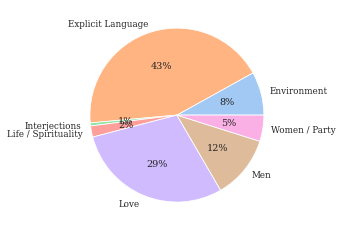

In [63]:
fig = plt.figure(figsize=(5,4))
plt.rcParams["font.family"] = 'serif'
values = topics_pie_dt['top_topic'].to_list()
labels = topics_pie_dt['top_topic_str'].to_list()

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(values, labels = labels, colors = colors, autopct='%.0f%%')
plt.savefig('../../data/output/figures/lyrics_topics_pie.eps')
plt.show()

Before and after outbreak

In [64]:
topics_pie_before_dt = pd.pivot_table(lyrics.loc[lyrics['release_date'] < '2020-03-01'], index='top_topic_str',
                                      values='top_topic',
                                      aggfunc='count').reset_index()
topics_pie_after_dt = pd.pivot_table(lyrics.loc[lyrics['release_date'] >= '2020-03-01'], index='top_topic_str',
                                      values='top_topic',
                                      aggfunc='count').reset_index()

In [65]:
len(lyrics['release_date'])

1252

In [66]:
print(sum(topics_pie_before_dt['top_topic']))
print(sum(topics_pie_after_dt['top_topic']))

779
455


In [67]:
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

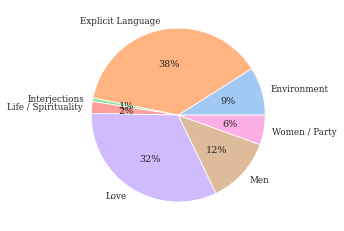

In [68]:
fig = plt.figure(figsize=(5,4))
plt.rcParams["font.family"] = 'serif'
values = topics_pie_before_dt['top_topic'].to_list()
labels = topics_pie_before_dt['top_topic_str'].to_list()

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(values, labels = labels, colors = colors, autopct='%.0f%%')
plt.savefig('../../data/output/figures/lyrics_topics_before_pie.eps')
plt.show()

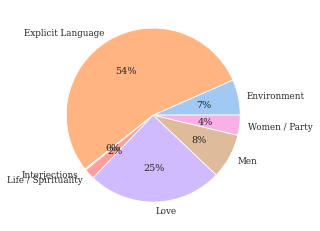

In [69]:
fig = plt.figure(figsize=(5,4))
plt.rcParams["font.family"] = 'serif'
values = topics_pie_after_dt['top_topic'].to_list()
labels = topics_pie_after_dt['top_topic_str'].to_list()

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(values, labels = labels, colors = colors, autopct='%.0f%%')
plt.savefig('../../data/output/figures/lyrics_topics_after_pie.eps')
plt.show()

In [70]:
topic_count_dt = pd.crosstab(index=bb_t100_topics['date'], columns=bb_t100_topics['top_topic_str'])
topic_count_dt

top_topic_str,Environment,Explicit Language,Interjections,Life / Spirituality,Love,Men,Women / Party
date,,,,,,,
2019-01-05,8,33,3,3,29,17,5
2019-01-12,10,36,0,4,35,5,6
2019-01-19,10,38,0,4,33,5,7
2019-01-26,9,36,0,4,34,5,9
2019-02-02,6,39,0,4,30,7,9
...,...,...,...,...,...,...,...
2020-12-05,8,27,2,1,29,20,5
2020-12-12,8,18,3,1,24,26,4
2020-12-19,10,21,4,2,24,28,3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


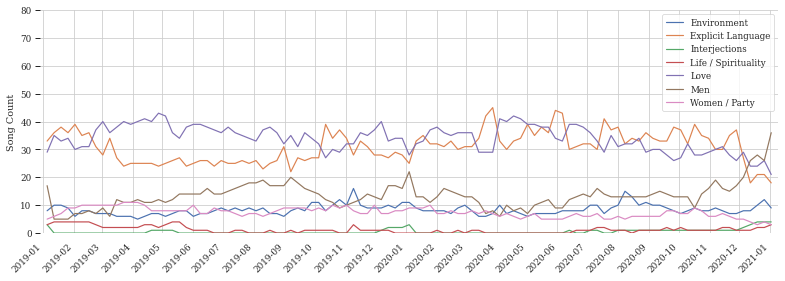

In [71]:
fig = plt.figure(figsize=(11, 4))
axes = fig.subplots()

for col in topic_count_dt.columns:
    sns.lineplot(data=topic_count_dt, x='date', y=col, label=col)



loc = matplotlib.dates.MonthLocator(interval=1)
axes.tick_params(axis="y", labelleft=True, labelright=False, left=True, right=False)
for k,v in axes.spines.items():
    v.set_visible(False)
axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(loc))
axes.set_xlabel(xlabel=None)
axes.set_ylabel(ylabel='Song Count')
axes.set_ylim(0,80)
axes.grid()
plt.gcf().autofmt_xdate()
axes.margins(x=0.01,tight=True)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../../data/output/figures/bb_t100_topics_line.eps')
plt.show()
plt.close()

In [72]:
love_dt = topic_count_dt
love_dt['rolling_avg'] = love_dt['Love'].rolling(12).mean().shift(-5)
love_dt = love_dt[['Love', 'rolling_avg']]
love_dt

top_topic_str,Love,rolling_avg
date,,
2019-01-05,29,NaN
2019-01-12,35,NaN
2019-01-19,33,NaN
2019-01-26,34,NaN
2019-02-02,30,NaN
...,...,...
2020-12-05,29,NaN
2020-12-12,24,NaN
2020-12-19,24,NaN


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


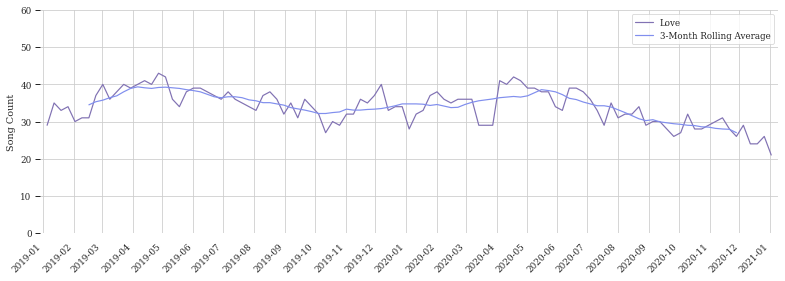

In [73]:
fig = plt.figure(figsize=(11, 4))
axes = fig.subplots()

sns.lineplot(data=topic_count_dt, x='date', y='Love', label='Love', color='#8172B3')
sns.lineplot(data=topic_count_dt, x='date', y='rolling_avg', label='3-Month Rolling Average', color='#818FEE')

loc = matplotlib.dates.MonthLocator(interval=1)
axes.tick_params(axis="y", labelleft=True, labelright=False, left=True, right=False)
for k,v in axes.spines.items():
    v.set_visible(False)
axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(loc))
axes.set_xlabel(xlabel=None)
axes.set_ylabel(ylabel='Song Count')
axes.set_ylim(0,60)
axes.grid()
plt.gcf().autofmt_xdate()
axes.margins(x=0.01,tight=True)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../../data/output/figures/bb_t100_topics_line_love.eps')
plt.show()
plt.close()

In [74]:
lyrics[['artist', 'song', 'topics', 'top_topic', 'topics_str', 'top_topic_str', '#topics']].head()

,artist,song,topics,top_topic,topics_str,top_topic_str,#topics
0,Ariana Grande,"Thank U, Next","{3: 0.56518024, 1: 0.2464887, 2: 0.1418631, 0:...",3,"[Life / Spirituality, Love, Explicit Language,...",Life / Spirituality,5
1,Halsey,Without Me,"{1: 0.5076201, 6: 0.24227798, 4: 0.18173535, 2...",1,"[Love, Women / Party, Environment, Explicit La...",Love,5
2,Mariah Carey,All I Want For Christmas Is You,"{0: 0.49855772, 1: 0.21124242, 6: 0.1829705, 4...",0,"[Men, Love, Women / Party, Environment]",Men,4
3,Travis Scott,Sicko Mode,"{2: 0.44927558, 0: 0.24981627, 4: 0.18896392, ...",2,"[Explicit Language, Men, Environment, Life / S...",Explicit Language,6
4,Post Malone & Swae Lee,Sunflower (Spider-Man: Into The Spider-Verse),"{1: 0.33934823, 4: 0.25219467, 6: 0.17150968, ...",1,"[Love, Environment, Women / Party, Men, Explic...",Love,5


In [75]:
lyrics[['topics', 'top_topic', '#topics']].describe()

,top_topic,#topics
count,1252.000000,1252.000000
mean,1.865815,5.094249
std,1.385507,1.042992
min,0.000000,1.000000
25%,1.000000,4.000000
50%,2.000000,5.000000
75%,2.000000,6.000000
max,6.000000,7.000000


In [76]:
covid_lyrics = pd.read_csv('../../data/lyrics/covid_lyrics_bb.csv', index_col=0)
merge_cols = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'lyrics_id',
              'topics', 'top_topic', 'topics_str', 'top_topic_str', '#topics']
covid_lyrics_topics = covid_lyrics.merge(lyrics[merge_cols], how='left', left_on='lyrics_id', right_on='lyrics_id',copy=False)
covid_lyrics_topics

,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,genius_id,lyrics,url,...,topic_2,topic_3,topic_4,topic_5,topic_6,topics,top_topic,topics_str,top_topic_str,#topics
0,6822,850,twenty one pilots,twenty one pilots,Level Of Concern,11.0,23.0,5428841,"Need you, tell me\r\nNeed you, tell me\r\n\r\n...",https://genius.com/Twenty-one-pilots-level-of-...,...,1,0,1,0,1,"{1: 0.83792096, 2: 0.085039444, 6: 0.032495108...",1,"[Love, Explicit Language, Women / Party, Men, ...",Love,5
1,6916,862,DaBaby Featuring YoungBoy Never Broke Again,DaBaby,Jump,4.0,17.0,5465136,"(Cha-ching)\r\nOkay, let's go, nigga\r\n(Rocco...",https://genius.com/Dababy-jump-lyrics,...,1,0,1,1,1,"{2: 0.68459517, 1: 0.11510832, 6: 0.09045522, ...",2,"[Explicit Language, Love, Women / Party, Men, ...",Explicit Language,6
2,6952,867,DaBaby Featuring Future & jetsonmade,DaBaby,LIGHTSKIN SHIT,1.0,53.0,5465365,"Uh, uh, uh-huh\r\nYeah (Oh Lord, Jetson made a...",https://genius.com/Dababy-lightskin-shit-lyrics,...,1,1,1,0,1,"{2: 0.74516505, 0: 0.12601738, 6: 0.059911422,...",2,"[Explicit Language, Men, Women / Party, Enviro...",Explicit Language,6
3,6963,870,DaBaby,DaBaby,BLAME IT ON BABY,1.0,64.0,5462131,"I'm like fuck it, let the beat build, nigga\r\...",https://genius.com/Dababy-blame-it-on-baby-lyrics,...,1,1,1,0,1,"{2: 0.58904177, 6: 0.13040444, 0: 0.12848634, ...",2,"[Explicit Language, Women / Party, Men, Love, ...",Explicit Language,6
4,7150,903,Drake,Drake,Losses,1.0,51.0,5520818,"Hey, Instagram\r\nThis song I've been writing,...",https://genius.com/Drake-losses-lyrics,...,1,1,1,0,0,"{1: 0.3790932, 0: 0.26616526, 2: 0.23477864, 4...",1,"[Love, Men, Explicit Language, Environment, Li...",Love,5
5,7157,905,Luke Combs,Luke Combs,Six Feet Apart,2.0,58.0,5466029,When the dogwoods start to bloom\r\nAnd the cr...,https://genius.com/Luke-combs-six-feet-apart-l...,...,1,0,1,0,1,"{0: 0.34485927, 4: 0.31848967, 1: 0.26786983, ...",0,"[Men, Environment, Love, Women / Party, Explic...",Men,5
6,7164,907,Lil Baby,Lil Baby,Social Distancing,1.0,65.0,5519310,(Section 8 just straight cooked this motherfuc...,https://genius.com/Lil-baby-social-distancing-...,...,1,1,1,0,1,"{2: 0.5724164, 0: 0.17064148, 1: 0.09248299, 3...",2,"[Explicit Language, Men, Love, Life / Spiritua...",Explicit Language,6
7,7200,912,Ariana Grande & Justin Bieber,Ariana Grande,Stuck With U,18.0,1.0,5524080,"Mmm\r\nHey, yeah\r\n(That's just for fun)\r\n(...",https://genius.com/Ariana-grande-and-justin-bi...,...,1,0,1,0,1,"{1: 0.38367915, 0: 0.29712003, 6: 0.18677768, ...",1,"[Love, Men, Women / Party, Environment, Explic...",Love,5
8,7202,913,6ix9ine,6ix9ine,Gooba,10.0,3.0,5545285,"I tell a nigga don't dick ride, don't blick ri...",https://genius.com/6ix9ine-gooba-lyrics,...,1,0,0,0,0,"{2: 0.83697015, 0: 0.124680765, 1: 0.019678911}",2,"[Explicit Language, Men, Love]",Explicit Language,3
9,7275,918,Chris Brown & Young Thug,Chris Brown,Go Crazy,33.0,9.0,5532594,"Oh, yeah\r\n(Oh, is that Kaniel again?)\r\nOh\...",https://genius.com/Chris-brown-and-young-thug-...,...,1,0,1,1,1,"{6: 0.3689718, 2: 0.29386818, 1: 0.23912875, 0...",6,"[Women / Party, Explicit Language, Love, Men, ...",Women / Party,6


In [77]:
topics_pie_covid_dt = pd.pivot_table(covid_lyrics_topics, index='top_topic_str',
                                      values='top_topic', dropna=False,
                                      aggfunc='count').reset_index()
topics_pie_covid_dt

,top_topic_str,top_topic
0,Environment,6
1,Explicit Language,17
2,Love,14
3,Men,7
4,Women / Party,2


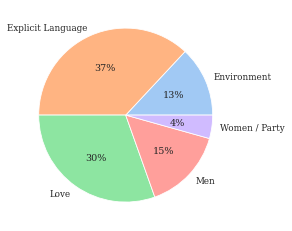

In [78]:
fig = plt.figure(figsize=(5,4))
plt.rcParams["font.family"] = 'serif'
values = topics_pie_covid_dt['top_topic'].to_list()
labels = topics_pie_covid_dt['top_topic_str'].to_list()

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(values, labels = labels, colors = colors, autopct='%.0f%%')
plt.savefig('../../data/output/figures/topics_pie_covid.eps')
plt.show()